# This is a code to solve Bankaya´s Challenge.

The objective is to create a model that detects which clients to approve and which to reject

In [1]:
#Load packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import pyarrow.parquet as pq

In [2]:
#Load databases
main_dataset = pd.read_parquet('Datasets/main_dataset.parquet')
credit_reports = pd.read_parquet('Datasets/credit_reports.parquet')

In [3]:
pd.set_option('display.max_columns', None)

# Check data quality and inspect datasets

The fist step is to explore the properties of both datasets and check the data quality. This is especially important if I am unfamiliar with the dataset. The conclusions where the following

- main_dataset is a high-quality dataset. The column types are read correctly. It has no duplicates. there is no missing information, except where the missing value is appropriate (e.g. first_app_date NaN if there was no other previous application). The description of the database gives enough information to grasp the content and procede
- credit_reports is also a high-quality dataset, but has more problems. The column types are read correctly. It has several duplicates, I believe that there probably was an additional column that was removed before handing me the data, I assume that the duplicate is just a coincidence where a custumer has two credits that are identical in all aspects, so I won´t remove duplicates.

Each customer is unique in main_dataset, while in credit_reports there are many credits for each customer.

Not all customers have a credit_report, possibly they have no experience with credit instruments

### Since I assume you know the database and need no further checks, I will put all these in the Appendix (end of the code)

# Step 2. Some observations for model selection

### do not use information that wouldn't be known at the moment of application
From main_dataset, there is a lot of information about the loan originated and how the customer behaved, however this wouldn't be known a the moment of origination for new customers, so it can't be incorporated as a feature in the model (possibly only as loss variables)

Unknown at moment of origination:
- FINANCED_AMOUNT
- LOAN_TERM_MONTHLY
- max_days_late
- target

It is trivial that if I were to incorporate, for example, max_days_late to the models, the accuracy would be near 100%. I did this in an exercise not shown here.

### not all applicants have info in credit_reports.
This means that for a large subset of applicant their information for approval will come from main_dataset

### credit_reports has a lot more complexity
The dataset credit_reports has a row for each credit opened by the applicant, there can be many loans and the interaction between them can be great, in addition there are more NAs in this dataset than in main.

### I want a model that not only classifies, but also gives the probability of being a bad borrower
The reason for this is that with an estimate of this probability, there can be two more recommendations that simple classification cannot give: priority order and interest rate. Priority order is important if there are more good applicants than funds, and interest rate is important to give personalized interest rate adjustments to each applicant, that depends on their risk.

# Model Proposal

I will stack two models.
1. First, using credit_reports I will fit a gradient boosting trees (CatBoost) to get the probability of being a bad borrower for each applicant that does have a credit report. I will use this output as an input in the second model
2. Second, using main_dataset I will fit simpler models that can give the ultimate classification and the underlying probabilities of being a bad borrower. This model will use the input of the first model when available and use the bayesian minimally informative prior (p=0.5) when this information is not available.


### Additional feature selection comments
Now I will use my knowledge to remove columns from the database that are clearly not helpful with discriminating custumers. This helps removing noise from the models.

Columns modified
- split_class, relabeled with new "train" and "test" with a 80/20 split

Columns removed from main_dataset:
- LOAN_ID, there is a single LOAN_ID for each CUSTOMER_ID in this datset. For simplicity I keep only CUSTOMER_ID
- LOAN_TYPE, all of them are "Arrendamiento"
- ACC_CREATION_DATETIME, since relevant info is in "account_to_application_days" and I don't plan to use temporal data such as which day of the week or in which month are there more "bad" accounts created. However this could be important in an extension
- APPLICATION_DATETIME, see above
- LOAN_ORIGINATION_DATETIME, time from aplication to origination is not exogenous from the characteristics of the customer

credit_application in general has to have its information aggregated by applicant and remain informative. This drives the decisions made in the first part of the model that include removing identificators and transforming datetime data to something more informative.

In [4]:
#Relabel costumers as "train" and "test"
test_size=0.2
main_dataset['split_class'] = np.where(np.random.rand(len(main_dataset)) < 0.8, 'train', 'test')

### Model 1. From credit reports get probability_target_credit

In [6]:
#create database with relevant information
credit_reports2 = credit_reports.drop(['LOAN_ID', 'INQUIRY_TIME', 'INQUIRY_DATE', 'LOAN_APPLICATION_ID', 'CDC_INQUIRY_ID', 'TOTAL_REPORTED_PAYMENTS',
                                      'REPORT_DATE', 'LOAN_APPLICATION_DATE', 'UPDATE_DATE', 'WORST_DELAY_DATE', 'LOAN_OPENING_DATE', 'LOAN_CLOSING_DATE',
                                      'CURRENT_PAYMENT', 'LAST_PURCHASE_DATE', 'LAST_PAYMENT_DATE'], axis = 1)

#add variables "days_since_x"
credit_reports2['days_since_update'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['UPDATE_DATE']).dt.days
credit_reports2['days_since_worst_delay'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['WORST_DELAY_DATE']).dt.days
credit_reports2['days_since_loan_opening'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['LOAN_OPENING_DATE']).dt.days
credit_reports2['days_since_loan_closing'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['LOAN_CLOSING_DATE']).dt.days
credit_reports2['days_since_last_purchase'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['LAST_PURCHASE_DATE']).dt.days
credit_reports2['days_since_last_payment'] = (credit_reports['LOAN_APPLICATION_DATE'] - credit_reports['LAST_PAYMENT_DATE']).dt.days

#merge the information about the target and the split class from main_dataset
credit_reports2 = credit_reports2.merge(main_dataset[['CUSTOMER_ID', 'target', 'split_class']], on='CUSTOMER_ID', how='left')

#Make sure all NAs are indeed NAs
credit_reports2.replace({None: np.nan}, inplace=True)

#Track categorical variables, the category none is distinct.
categorical_variables = ['PREVENTION_KEY', 'CURRENCY', 'PAYMENT_FREQUENCY', 'BUSINESS_TYPE', 'CREDIT_TYPE', 'ACCOUNT_TYPE',
                                         'RESPONSABILITY_TYPE']

credit_reports2[categorical_variables] = credit_reports2[categorical_variables].fillna("unknown")
credit_reports2.describe(include='all', datetime_is_numeric = True)

,CUSTOMER_ID,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,PAYMENT_FREQUENCY,BUSINESS_TYPE,CREDIT_TYPE,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,WORST_DELAY,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY,days_since_update,days_since_worst_delay,days_since_loan_opening,days_since_loan_closing,days_since_last_purchase,days_since_last_payment,target,split_class
count,2.873560e+05,287356,287356,2.871740e+05,2.789990e+05,2.872670e+05,287356,287356,287356,287356,287356,268711.000000,287267,284146.000000,2.872670e+05,2.872670e+05,2.872670e+05,287267.000000,84658.000000,287267.000000,192609.000000,283214.000000,255679.000000,287356.000000,287356
unique,NaN,32,4,NaN,NaN,NaN,12,59,34,7,6,NaN,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,SIN OBSERVACION,PESOS MEXICANOS,NaN,NaN,NaN,MENSUAL,MICROFINANCIERA,PRESTAMO PERSONAL,PAGOS FIJOS,INDIVIDUAL (TITULAR),NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
freq,NaN,194656,287249,NaN,NaN,NaN,124398,67568,129865,224372,268710,NaN,204496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230003
mean,7.184297e+05,NaN,NaN,1.528038e+04,5.525842e+03,1.670948e+03,NaN,NaN,NaN,NaN,NaN,22.773876,NaN,4.278790,4.578483e+03,2.090321e+03,1.671462e+03,987.654067,1214.834156,1477.203097,1507.109901,1390.553620,1340.069243,0.167513,NaN
std,3.268016e+05,NaN,NaN,1.313088e+06,2.788269e+04,1.301032e+04,NaN,NaN,NaN,NaN,NaN,89.005749,NaN,12.231546,3.554325e+04,1.411186e+04,1.164611e+04,1265.938658,1471.873779,1464.472265,1410.016659,1397.789818,1362.013353,0.373434,NaN
min,1.020000e+02,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,3.000000,7.000000,2.000000,4.000000,2.000000,0.000000,NaN
25%,4.684650e+05,NaN,NaN,5.480000e+02,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,173.000000,224.000000,429.000000,446.000000,395.000000,355.000000,0.000000,NaN
50%,8.504110e+05,NaN,NaN,2.300000e+03,4.000000e+02,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,384.000000,539.000000,955.000000,1036.000000,861.000000,824.000000,0.000000,NaN
75%,9.788870e+05,NaN,NaN,7.483000e+03,3.000000e+03,1.490000e+02,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,2.000000,2.730000e+02,0.000000e+00,1.590000e+02,1358.000000,1672.000000,2082.000000,2136.000000,1952.000000,1914.000000,0.000000,NaN


In [7]:
#Now aggregate credit information so that each unique CUSTOMER_ID has all its info in a single row
## Note: This is probably where there is more opportunity to improve

def prevention(series):
    ret = 'SIN OBSERVACION'
    if sum(~series.isin(['SIN OBSERVACION', 'CUENTA CANCELADA O CERRADA'])) > 0:
        ret = series[~series.isin(['SIN OBSERVACION', 'CUENTA CANCELADA O CERRADA'])].mode()[0]
    return ret

def most_frequent(series):
    return series.mode()[0]

aggregated_df = credit_reports2.groupby('CUSTOMER_ID').agg({
    'WORST_DELAY': 'sum',
    'DELAYED_PAYMENTS': 'sum',
    'BALANCE_DUE_WORST_DELAY': 'sum',
    'PREVENTION_KEY': prevention,
    'BALANCE_DUE': 'sum',
    'target': 'mean',
    'PAYMENT_AMOUNT': 'sum',
    'split_class': most_frequent,
    'ACCOUNT_TYPE': most_frequent,
    'RESPONSABILITY_TYPE': most_frequent,
    'PAYMENT_FREQUENCY': most_frequent,
    'MAX_CREDIT': 'max',
    'days_since_loan_opening': 'min',
    'days_since_worst_delay': 'min'
}).reset_index()

#add info about count of number of loans
aggregated_df = pd.merge(aggregated_df, credit_reports2.groupby('CUSTOMER_ID').size().reset_index(name='n_loans'), on='CUSTOMER_ID', how='left')

In [8]:
# Splitting the data into training and testing sets for CREDIT REPORTS
# Split the dataframe based on the 'split' column
df = aggregated_df

train_data = df[df['split_class'] == 'train'].drop(columns='split_class')
test_data = df[df['split_class'] == 'test'].drop(columns='split_class')

X_train = train_data.drop(columns=['target', 'CUSTOMER_ID'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target', 'CUSTOMER_ID'])
y_test = test_data['target']

y_test2 = test_data[['CUSTOMER_ID','target']]

In [9]:
#Since the sample has many more "good borrowers" than bad, and the cost of misclassifying a bad borrower is greater, I have to input weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

train_data = Pool(data=X_train, label=y_train, cat_features=['PREVENTION_KEY', 'ACCOUNT_TYPE', 'RESPONSABILITY_TYPE', 'PAYMENT_FREQUENCY'])

# Create the model
model = CatBoostClassifier(iterations=3000, depth=4, learning_rate=0.15, class_weights = class_weights)
model.fit(train_data, verbose = 100)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0:	learn: 0.6910238	total: 180ms	remaining: 8m 59s
100:	learn: 0.6231522	total: 4.29s	remaining: 2m 3s
200:	learn: 0.5652205	total: 7.37s	remaining: 1m 42s
300:	learn: 0.5180234	total: 10.8s	remaining: 1m 37s
400:	learn: 0.4799276	total: 14.8s	remaining: 1m 36s
500:	learn: 0.4457584	total: 17.8s	remaining: 1m 28s
600:	learn: 0.4154202	total: 20.8s	remaining: 1m 23s
700:	learn: 0.3859433	total: 23.7s	remaining: 1m 17s
800:	learn: 0.3607604	total: 27.4s	remaining: 1m 15s
900:	learn: 0.3350051	total: 31.2s	remaining: 1m 12s
1000:	learn: 0.3155883	total: 34s	remaining: 1m 7s
1100:	learn: 0.2947475	total: 36.9s	remaining: 1m 3s
1200:	learn: 0.2762995	total: 39.8s	remaining: 59.7s
1300:	learn: 0.2602547	total: 43.8s	remaining: 57.1s
1400:	learn: 0.2439836	total: 47.5s	remaining: 54.2s
1500:	learn: 0.2309858	total: 50.3s	remaining: 50.2s
1600:	learn: 0.2173794	total: 53.1s	remaining: 46.4s
1700:	learn: 0.2040270	total: 55.9s	remaining: 42.7s
1800:	learn: 0.1927609	total: 59.6s	remaining: 39.7

In [10]:
#Now that I have an estimated model, calculate the probability_target_credit and add it to the databse
probability_target_credit_df = pd.DataFrame(model.predict_proba(aggregated_df.drop(columns=['target', 'CUSTOMER_ID', 'split_class']))[:, 1], columns = ['probability_target_credit'])
credit_reports3 = pd.concat([aggregated_df, probability_target_credit_df], axis = 1)

### Model 2. Use input from previous model and get final probabilities

In [11]:
#create database with relevant information
main_dataset2 = main_dataset.drop(['LOAN_ID', 'LOAN_TYPE', 'ACC_CREATION_DATETIME', 'APPLICATION_DATETIME', 'LOAN_ORIGINATION_DATETIME',
                                  'first_app_date', 'last_app_date', 'first_bnpl_app_date', 'last_bnpl_app_date'], axis = 1)

#Creates new variables: days since x
main_dataset2['days_since_first_app'] = (main_dataset['APPLICATION_DATETIME'] - main_dataset['first_app_date']).dt.days
main_dataset2['days_since_last_app'] = (main_dataset['APPLICATION_DATETIME'] - main_dataset['last_app_date']).dt.days
main_dataset2['days_since_first_bnpl'] = (main_dataset['APPLICATION_DATETIME'] - main_dataset['first_bnpl_app_date']).dt.days
main_dataset2['days_since_last_bnpl'] = (main_dataset['APPLICATION_DATETIME'] - main_dataset['last_bnpl_app_date']).dt.days

#Merge some probability_target_credit from the credit_report

main_dataset2 = pd.merge(main_dataset2, credit_reports3.groupby('CUSTOMER_ID')['probability_target_credit'].mean().reset_index(), on='CUSTOMER_ID', how='left')
main_dataset2['probability_target_credit'] = main_dataset2['probability_target_credit'].fillna(0.50) #Bayesian prior of 0.50

#For extra safety I add a binary variable has_credit_report that shows if the CUSTOMER_ID has a credit report.
## Number of loans
main_dataset2 = pd.merge(main_dataset2, credit_reports.groupby('CUSTOMER_ID').size().reset_index(name='n_loans'), on='CUSTOMER_ID', how='left')
main_dataset2.replace({None: np.nan}, inplace=True)
main_dataset2['n_loans'] = main_dataset2['n_loans'].fillna(0)
main_dataset2['has_credit_report'] = np.where(main_dataset2['n_loans'] > 0, 1, 0)
main_dataset2.drop('n_loans', axis = 1, inplace = True)

In [12]:
#To improve the interpretation of the model I will scale some features

do_not_scale = ['has_credit_report', 'has_inquiries', 'has_sf', 'has_bnpl', 'probability_target_credit',
                   'target', 'CUSTOMER_ID', 'FINANCED_AMOUNT', 'LOAN_TERM_MONTHLY', 'max_days_late', 'split_class']

features_to_scale = main_dataset2.drop(do_not_scale, axis = 1).columns

# Separate the features to scale and not to scale
df_to_scale = main_dataset2[features_to_scale].fillna(0)
df_not_scale = main_dataset2.drop(columns=features_to_scale)

# Scale the selected features
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_to_scale)
df_scaled = pd.DataFrame(scaled_array, columns=features_to_scale)

# Concatenate back for the complete preprocessed data
main_dataset3 = pd.concat([df_scaled, df_not_scale], axis=1)

In [13]:
# Splitting the data into training and testing sets for MAIN DATASET
# Split the dataframe based on the 'split' column
df = main_dataset3

train_data = df[df['split_class'] == 'train'].drop(columns='split_class')
test_data = df[df['split_class'] == 'test'].drop(columns='split_class')

#Remember to drop columns that would not be known for a new customer
X_train = train_data.drop(columns=['target', 'CUSTOMER_ID', 'FINANCED_AMOUNT', 'LOAN_TERM_MONTHLY', 'max_days_late'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target', 'CUSTOMER_ID', 'FINANCED_AMOUNT', 'LOAN_TERM_MONTHLY', 'max_days_late'])
y_test = test_data['target']

### Best model, simple logistic regression.
It is the best model since it has a recall percentage of 85%, which means that a bad borrower in the test sample is correctly identified 85% of the time. At the same time it doesn't sacrifice too much other measures of accuracy. The negative aspect is that this model "cries wolf" too much, but if this makes the pool of applicants too small we can always use the ranking given by the model to choose approve more applicants.

The reason for the good performance of this model is:
- Transformations done to scale continuous data, this also improves interpretability
- more weight is given to the bad borrowers in the sample, since they are more rare
- probability_target_credit obtained in the first model is the most important factor to discriminate good and bad borrowers when available.
- main_database has a simpler structure, so the logistic model is very powerful.

In [14]:
# Create the model
model1 = LogisticRegression(class_weight='balanced', max_iter=10000)
model1.fit(X_train, y_train)

# Predicting on the scaled test set
y_pred = model1.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6220665499124344
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      2305
           1       0.25      0.48      0.33       550

    accuracy                           0.62      2855
   macro avg       0.55      0.57      0.53      2855
weighted avg       0.73      0.62      0.66      2855



In [15]:
#To see the relative impotantce of each coefficient
coefficients = model1.coef_[0]
feature_names = X_train.columns
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

print("Feature\t\tCoefficient")
print("------------------------")
for index in sorted_indices:
    print(f"{feature_names[index]:<10}\t{coefficients[index]:.4f}")

Feature		Coefficient
------------------------
probability_target_credit	13.8699
days_since_last_bnpl	0.5518
has_bnpl  	-0.4989
has_sf    	-0.3755
days_since_first_bnpl	-0.3502
account_to_application_days	-0.2734
n_inquiries_l6m	0.2519
has_inquiries	0.2267
days_since_last_app	0.1792
n_inquiries_l3m	-0.1234
days_since_first_app	0.0743
n_bnpl_apps	-0.0471
n_bnpl_approved_apps	0.0454
n_inquiries	-0.0445
has_credit_report	0.0308
n_sf_apps 	-0.0093


## Example of loan selection
From the pool of 2911 applicants (in the test data) select the 1500 best. at an average of $4000 per loan, this means loaning 6 million

The selected applicants have a probability of being bad borrowers ranging from 1.8% to 39.3%. The ex-post delinquency rate is 4.1%.

The negative aspect is that only 6% of the applicants without a credit history were selected, maybe an improvement to the information about applicants without credit history can be beneficial, especially if they are the target demographic.

In addition, since each applicant has a probability of default I can give personalized interest rate recommendations given by.

Since the rate of retrun given probability of default p is $(1+r)(1-p)$ a idea is to scale the interest rate by 1/(1-p) where p is the prbability_target estimated.

In [16]:
probability_target_df = pd.DataFrame(model1.predict_proba(X_test)[:, 1], columns = ['probability_target'])
probability_target_df2 = pd.concat([test_data.reset_index(), probability_target_df], axis = 1)[['CUSTOMER_ID', 'probability_target', 'target', 'has_credit_report']]

n_select = 1500
ID_selected = probability_target_df2.sort_values(by='probability_target').head(n_select)
ID_selected

,CUSTOMER_ID,probability_target,target,has_credit_report
1454,75047,0.000351,0,1
1232,108642,0.000383,0,1
107,253677,0.000393,1,1
1054,2287,0.000398,0,1
437,16816,0.000425,0,1
...,...,...,...,...
1090,700987,0.273468,0,1
2237,132096,0.273518,1,1
1448,838625,0.281936,0,1
2779,534270,0.282153,0,1


In [17]:
print(ID_selected['probability_target'].min())
print(ID_selected['probability_target'].max())
print(ID_selected['target'].mean())
print(ID_selected['has_credit_report'].mean())

0.00035069742845979414
0.28231096164401553
0.16066666666666668
0.996


### Other models

### Naive Bayes

In [18]:
class_weights = 1. / np.bincount(y_train)
sample_weights = class_weights[y_train]

model2 = GaussianNB()
model2.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting on the scaled test set
y_pred = model2.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.750262697022767
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2305
           1       0.27      0.18      0.21       550

    accuracy                           0.75      2855
   macro avg       0.55      0.53      0.53      2855
weighted avg       0.71      0.75      0.73      2855



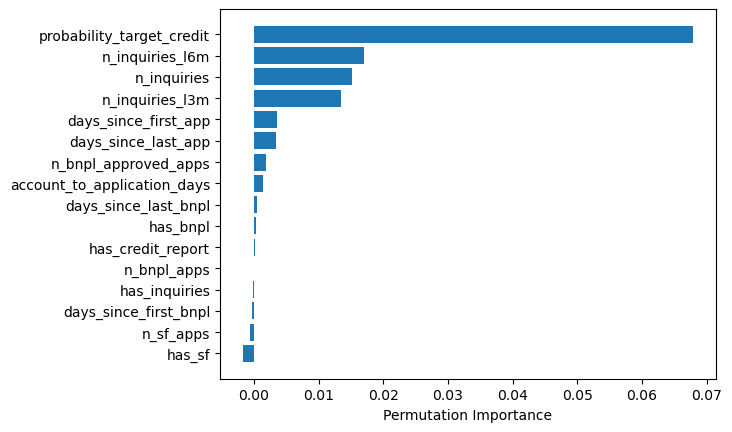

In [19]:
# Compute permutation importance
result = permutation_importance(model2, X_test, y_test, n_repeats=30)

sorted_idx = result.importances_mean.argsort()

plt.barh(range(X_train.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### XGBoost

In [20]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Create an XGBoost classifier instance
model3 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=ratio, n_estimators = 2000)

# Fit the model to the training data
model3.fit(X_train, y_train)

# You can now make predictions using this model
y_pred = model3.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6245183887915937
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      2305
           1       0.24      0.44      0.31       550

    accuracy                           0.62      2855
   macro avg       0.54      0.55      0.53      2855
weighted avg       0.72      0.62      0.66      2855



# Appendix. Checks of data quality

In [21]:
print(main_dataset.dtypes)
print(credit_reports.dtypes)

LOAN_ID                                 int64
CUSTOMER_ID                             int64
ACC_CREATION_DATETIME          datetime64[ns]
APPLICATION_DATETIME           datetime64[ns]
LOAN_ORIGINATION_DATETIME      datetime64[ns]
FINANCED_AMOUNT                       float64
LOAN_TERM_MONTHLY                       int64
LOAN_TYPE                              object
max_days_late                           int64
target                                  int64
account_to_application_days             int64
n_sf_apps                             float64
first_app_date                 datetime64[ns]
last_app_date                  datetime64[ns]
n_bnpl_apps                           float64
n_bnpl_approved_apps                  float64
first_bnpl_app_date            datetime64[ns]
last_bnpl_app_date             datetime64[ns]
n_inquiries                           float64
n_inquiries_l3m                       float64
n_inquiries_l6m                       float64
has_sf                            

In [22]:
#Returns missing values as percentage.
missing_values1 = main_dataset.isna().sum()/main_dataset.shape[0]*100
missing_values2 = credit_reports.isna().sum()/credit_reports.shape[0]*100
print(missing_values1)
print(missing_values2)

LOAN_ID                         0.000000
CUSTOMER_ID                     0.000000
ACC_CREATION_DATETIME           0.000000
APPLICATION_DATETIME            0.000000
LOAN_ORIGINATION_DATETIME       0.000000
FINANCED_AMOUNT                 0.000000
LOAN_TERM_MONTHLY               0.000000
LOAN_TYPE                       0.000000
max_days_late                   0.000000
target                          0.000000
account_to_application_days     0.000000
n_sf_apps                      52.912689
first_app_date                 52.912689
last_app_date                  52.912689
n_bnpl_apps                    39.539228
n_bnpl_approved_apps           39.539228
first_bnpl_app_date            39.539228
last_bnpl_app_date             39.539228
n_inquiries                    37.159264
n_inquiries_l3m                37.159264
n_inquiries_l6m                37.159264
has_sf                          0.000000
has_bnpl                        0.000000
has_inquiries                   0.000000
split_class     

In [23]:
# Unique values in main_dataset. The objective is to understand better the dataset and see if there are any mistakes
for column in main_dataset.columns:
    if main_dataset[column].dtypes not in ['datetime64[ns]', 'datetime64[ns, UTC]']:
        unique_values = main_dataset[column].unique()
        print(f"Unique values in column {column}:")
        print(unique_values)
        print("\n")

Unique values in column LOAN_ID:
[149900 153090 154685 ... 381179 381632 383998]


Unique values in column CUSTOMER_ID:
[ 710278  825235  811344 ...  137446 1169822 1053785]


Unique values in column FINANCED_AMOUNT:
[2100.   3999.   2700.   4769.   2880.   3060.   4124.   5279.   2309.
 4249.   1539.   2520.   2379.   2099.   2239.   2970.   4500.   4319.
 2790.   4454.   3499.   5609.   4599.   5000.   5114.   4049.   1959.
 3749.   5444.   5599.   3779.   3299.   2600.   4949.   2340.   1000.
 2169.   2609.   4589.   3624.   3000.   2160.   1119.   3050.   2749.
 1980.   2000.   4099.   5069.   1889.   4399.   5099.   2800.   2489.
 4619.   3914.   2020.   1449.   1775.   4184.   2142.25 2448.25 2081.
 1836.   2372.25 1897.   2601.25 1653.   2295.25 2525.25 1714.   1346.
 3479.   3959.   4419.   4289.   3639.   3769.   3562.   4029.   3199.
 3443.   4620.67 2859.   3899.   1949.   4909.67 5269.   4959.   4485.78
 4037.   3839.   4079.   3918.   4156.   3800.   4549.   5579.   4275.


In [24]:
# Unique values in credit_reports. The objective is to understand better the dataset and see if there are any mistakes
for column in credit_reports.columns:
    if credit_reports[column].dtypes not in ['datetime64[ns]', 'datetime64[ns, UTC]']:
        unique_values = credit_reports[column].unique()
        print(f"Valores de {column}:")
        print(unique_values)
        print("\n")

Valores de CUSTOMER_ID:
[ 710278  622857  875073 ... 1020226  137446 1053785]


Valores de LOAN_ID:
[149900 154847 155561 ... 379134 381179 383998]


Valores de LOAN_APPLICATION_ID:
['866f9a8e52c5a156233740074f56952b' '2498fb8c86bf283501daa7bbfcdaa60f'
 '865b3ed9964ee2ccfffd5401ca00c08d' ...
 'adf6969e-d3cc-11ed-8ac3-3e7f397f2bf6'
 '764bc422-f8c4-11ed-a350-aef900c315d0'
 'ca341dd8-fc4c-11ed-8e44-aef900c315d0']


Valores de CDC_INQUIRY_ID:
['710278-27993a6e-2885-48d4-a753-9249e7022af1'
 '622857-6b4e9d95-7491-40c3-bccd-442de7f94c58'
 '875073-46a5f149-19db-4193-b92a-b8f41fb3e896' ...
 '1020226-d6f6b335-3fec-4f11-ab71-005e55f492a3'
 '137446-af7447eb-4146-40ec-92b5-d71c167fc1d1'
 '1053785-35891c8d-97ba-4dce-9f5f-e7bf8684473a']


Valores de PREVENTION_KEY:
['SIN OBSERVACION' 'CUENTA CANCELADA O CERRADA'
 'CONVENIO DE FINIQUITO O PAGO MENOR'
 'CUENTA REESTRUCTURADA SIN PAGO MENOR POR MODIFICACION DE LA SITUACION DEL CLIENTE'
 'CUENTA EN COBRANZA' 'CUENTA QUE CAUSA QUEBRANTO'
 'CUENTA QUE NO E

In [25]:
# Checks if there are duplicated rows
duplicated_rows1 = main_dataset[main_dataset.duplicated(keep=False)]
duplicated_rows2 = credit_reports[credit_reports.duplicated(keep=False)]
print(duplicated_rows1)
print(duplicated_rows2)

Empty DataFrame
Columns: [LOAN_ID, CUSTOMER_ID, ACC_CREATION_DATETIME, APPLICATION_DATETIME, LOAN_ORIGINATION_DATETIME, FINANCED_AMOUNT, LOAN_TERM_MONTHLY, LOAN_TYPE, max_days_late, target, account_to_application_days, n_sf_apps, first_app_date, last_app_date, n_bnpl_apps, n_bnpl_approved_apps, first_bnpl_app_date, last_bnpl_app_date, n_inquiries, n_inquiries_l3m, n_inquiries_l6m, has_sf, has_bnpl, has_inquiries, split_class]
Index: []
        CUSTOMER_ID                     INQUIRY_TIME  LOAN_ID  \
12           693356 2022-03-13 01:46:41.593000+00:00   155789   
13           693356 2022-03-13 01:46:41.593000+00:00   155789   
475          203141 2021-08-11 20:26:28.974000+00:00   156863   
476          203141 2021-08-11 20:26:28.974000+00:00   156863   
663          670945 2022-03-05 06:33:27.333000+00:00   157033   
...             ...                              ...      ...   
286682       364737 2023-03-12 16:58:53.363000+00:00   361705   
287270      1079691 2023-01-29 20:25:40.

In [26]:
main_dataset.describe(include='all', datetime_is_numeric = True)

,LOAN_ID,CUSTOMER_ID,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,FINANCED_AMOUNT,LOAN_TERM_MONTHLY,LOAN_TYPE,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,last_app_date,n_bnpl_apps,n_bnpl_approved_apps,first_bnpl_app_date,last_bnpl_app_date,n_inquiries,n_inquiries_l3m,n_inquiries_l6m,has_sf,has_bnpl,has_inquiries,split_class
count,14454.000000,1.445400e+04,14454,14454,14454,14454.000000,14454.000000,14454,14454.000000,14454.000000,14454.000000,6806.000000,6806,6806,8739.000000,8739.000000,8739,8739,9083.000000,9083.000000,9083.000000,14454.000000,14454.000000,14454.000000,14454
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARRENDAMIENTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11599
mean,255639.865643,7.815302e+05,2022-06-17 07:24:49.443337216,2022-11-28 03:42:40.896637696,2022-12-28 06:04:09.504220160,3817.210331,8.646741,NaN,14.225889,0.186800,163.489000,1.653982,2022-06-16 04:31:39.970614272,2022-06-16 01:42:11.531002112,1.221765,0.264904,2022-08-13 09:30:46.852090624,2022-08-03 09:11:07.589265152,28.099086,10.350435,17.114830,0.470873,0.604608,0.383562,NaN
min,149900.000000,1.020000e+02,2020-10-14 18:22:10,2022-04-26 07:00:00,2022-07-01 09:03:20,600.000000,3.000000,NaN,-7.000000,0.000000,0.000000,1.000000,2021-04-27 00:00:00,2021-04-25 00:00:00,1.000000,0.000000,2022-01-06 21:17:08.193000,2022-01-06 21:17:08.193000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,208709.000000,6.153128e+05,2022-02-21 18:46:22.249999872,2022-09-15 13:00:00,2022-10-27 21:15:58.249999872,2879.000000,6.000000,NaN,0.000000,0.000000,0.000000,1.000000,2022-02-27 00:00:00,2022-02-25 00:00:00,1.000000,0.000000,2022-05-01 21:03:56.963500032,2022-04-20 05:33:33.585999872,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,256540.000000,8.998375e+05,2022-07-19 20:29:43.500000,2022-12-20 08:00:00,2023-01-11 10:05:49.500000,3599.000000,9.000000,NaN,2.000000,0.000000,103.000000,1.000000,2022-07-15 00:00:00,2022-07-16 00:00:00,1.000000,0.000000,2022-08-18 13:36:14.271000064,2022-07-28 17:37:41.676999936,21.000000,0.000000,8.000000,0.000000,1.000000,0.000000,NaN
75%,299747.250000,1.014050e+06,2022-11-13 07:37:39.249999872,2023-02-04 08:00:00,2023-03-06 18:07:46.249999872,4615.835000,12.000000,NaN,20.000000,0.000000,271.750000,2.000000,2022-10-21 00:00:00,2022-10-22 00:00:00,1.000000,0.000000,2022-11-06 19:24:55.189499904,2022-11-06 01:50:47.641999872,38.000000,14.000000,26.000000,1.000000,1.000000,1.000000,NaN
max,383998.000000,1.193468e+06,2023-05-19 19:55:04,2023-05-26 07:00:00,2023-05-29 12:18:28,8998.750000,12.000000,NaN,70.000000,1.000000,901.000000,42.000000,2023-05-12 00:00:00,2023-05-12 00:00:00,18.000000,15.000000,2023-05-20 17:15:47,2023-05-17 15:20:48,213.000000,170.000000,213.000000,1.000000,1.000000,1.000000,NaN


In [27]:
credit_reports.describe(include='all', datetime_is_numeric = True)

,CUSTOMER_ID,INQUIRY_TIME,LOAN_ID,LOAN_APPLICATION_ID,LOAN_APPLICATION_DATE,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,LOAN_OPENING_DATE,LOAN_CLOSING_DATE,WORST_DELAY_DATE,REPORT_DATE,LAST_PURCHASE_DATE,LAST_PAYMENT_DATE,PAYMENT_FREQUENCY,BUSINESS_TYPE,CREDIT_TYPE,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
count,2.873560e+05,287356,287356.000000,287356,287356,287267,287267,287267,287267,2.871740e+05,2.789990e+05,2.872670e+05,287267,287267,192609,84658,287267,283214,255679,287267,287267,287267,287267,287267,268711.000000,287267,287267,284146.000000,245415,2.872670e+05,2.872670e+05,2.872670e+05
unique,NaN,NaN,NaN,9249,NaN,9172,NaN,31,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,58,33,6,5,NaN,97,86,NaN,1,NaN,NaN,NaN
top,NaN,NaN,NaN,b4f8bbdae91eaa1942b57b832eb9c890,NaN,742024-7875e341-c277-4455-b929-1bb5cce01849,NaN,SIN OBSERVACION,PESOS MEXICANOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MENSUAL,MICROFINANCIERA,PRESTAMO PERSONAL,PAGOS FIJOS,INDIVIDUAL (TITULAR),NaN,0,V,NaN,0,NaN,NaN,NaN
freq,NaN,NaN,NaN,269,NaN,269,NaN,194656,287249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124398,67568,129865,224372,268710,NaN,204496,223486,NaN,245415,NaN,NaN,NaN
mean,7.184297e+05,2022-07-02 13:56:59.081574656+00:00,264915.320025,NaN,2022-12-09 03:45:22.400089088,NaN,2022-07-02 00:44:25.383771392,NaN,NaN,1.528038e+04,5.525842e+03,1.670948e+03,2020-03-26 04:35:03.002433024,2018-11-22 15:24:26.870889984,2018-10-24 21:45:09.910752,2019-08-11 02:14:42.969123072,2020-03-22 05:43:32.962853376,2019-02-17 08:26:14.566228992,2019-04-09 00:51:00.575174400,NaN,NaN,NaN,NaN,NaN,22.773876,NaN,NaN,4.278790,NaN,4.578483e+03,2.090321e+03,1.671462e+03
min,1.020000e+02,2021-04-29 22:50:03.745000+00:00,149900.000000,NaN,2022-04-26 07:00:00,NaN,2021-04-29 00:00:00,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2001-04-25 00:00:00,1950-01-01 00:00:00,2000-08-28 00:00:00,1998-10-10 00:00:00,2001-04-25 00:00:00,1950-01-01 00:00:00,1950-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.684650e+05,2022-03-22 21:03:45.144000+00:00,231209.000000,NaN,2022-10-22 07:00:00,NaN,2022-03-22 00:00:00,NaN,NaN,5.480000e+02,0.000000e+00,0.000000e+00,2019-03-13 00:00:00,2017-03-21 00:00:00,2017-01-30 00:00:00,2018-04-30 00:00:00,2019-02-28 00:00:00,2017-07-29 00:00:00,2017-09-02 00:00:00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.504110e+05,2022-07-18 18:09:13.480999936+00:00,267183.000000,NaN,2022-12-25 08:00:00,NaN,2022-07-18 00:00:00,NaN,NaN,2.300000e+03,4.000000e+02,0.000000e+00,2021-11-22 00:00:00,2020-04-02 00:00:00,2020-01-27 00:00:00,2021-05-31 00:00:00,2021-11-10 00:00:00,2020-08-03 00:00:00,2020-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.788870e+05,2022-10-27 00:27:07.930249984+00:00,304952.000000,NaN,2023-02-05 08:00:00,NaN,2022-10-27 00:00:00,NaN,NaN,7.483000e+03,3.000000e+03,1.490000e+02,2022-06-15 00:00:00,2021-10-14 00:00:00,2021-09-20 00:00:00,2022-04-20 00:00:00,2022-06-12 00:00:00,2021-11-16 00:00:00,2021-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,2.000000,NaN,2.730000e+02,0.000000e+00,1.590000e+02
max,1.169801e+06,2023-05-17 15:20:36.890000+00:00,383998.000000,NaN,2023-05-26 07:00:00,NaN,2023-05-17 00:00:00,NaN,NaN,4.040404e+08,1.900000e+06,1.800000e+06,2023-05-07 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-04-12 00:00:00,2023-05-07 00:00:00,2023-04-07 00:00:00,2023-05-07 00:00:00,NaN,NaN,NaN,NaN,NaN,1800.000000,NaN,NaN,84.000000,NaN,3.469743e+06,1.800000e+06,1.800000e+06


In [28]:
# Import necessary libraries
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Initialize a Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=10)

# Output the results
print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV scores:", cv_scores.std())

Cross-validation scores: [1.         0.93333333 1.         0.93333333 0.93333333 0.86666667
 0.93333333 0.93333333 1.         1.        ]
Mean CV Score: 0.9533333333333334
Standard Deviation of CV scores: 0.04268749491621898
